In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
import xml.etree.ElementTree as ET
import pickle
import os
plt.style.use('ggplot')
%matplotlib inline
os.chdir('/home/allen/Documents/data incubator/proposed project')
survey2016 = pd.read_csv('Survey Data/2016 Stack Overflow Survey Responses.csv')

# Does stackoverflow lower wages?

## Outline

* Exponential growth of stack overflow
* Initial look at wages and information availability
* Survey's own education data
* Second look at wages, controlling for geography
* A simple regression

## To be continued...
* country map of stackoverflow growth
* Can we specify a causal regression using time series data? (which way does causality flow, worse developers to greater number of posts, or greater number of posts to lower salaries?)
* Other fields in the survey and stack overflow data dump
* deeper exploration of stack overflow posts: what does the number of posts indicate about the quality of information?
* deeper exploration of stack overflow posts: other indicators for quality?
* scraping developer profiles on stackoverflow
* data on MOOCs


### Graph 1, growth of Cross Validated

How is this trend increasing over time? Is it an important economic force?

In [3]:
## Create a timeseries graph of users and posts over time on Cross Validated
dusers = pd.read_csv("stats.stackexchange.com/Users.csv")
dposts = pd.read_csv("stats.stackexchange.com/Posts.csv")

dposts['CreationDate'] = pd.to_datetime(dposts['CreationDate'], format='%Y-%m-%dT%H:%M:%S.%f')
dposts['Date'] = dposts.CreationDate.dt.date

dusers.CreationDate = pd.to_datetime(dusers['CreationDate'], format='%Y-%m-%dT%H:%M:%S.%f')
dusers['Date'] = dusers.CreationDate.dt.date
usercounts = dusers.groupby('Date').size()
postcounts = dposts.groupby('Date').size()
posts_users = pd.DataFrame(data={"users": usercounts.cumsum(),
                                 "posts": postcounts},
                           index=postcounts.index)

posts_users['users30dayMA'] = posts_users['users'].rolling(window=30).mean()
posts_users['posts30dayMA'] = posts_users['posts'].rolling(window=30).mean()

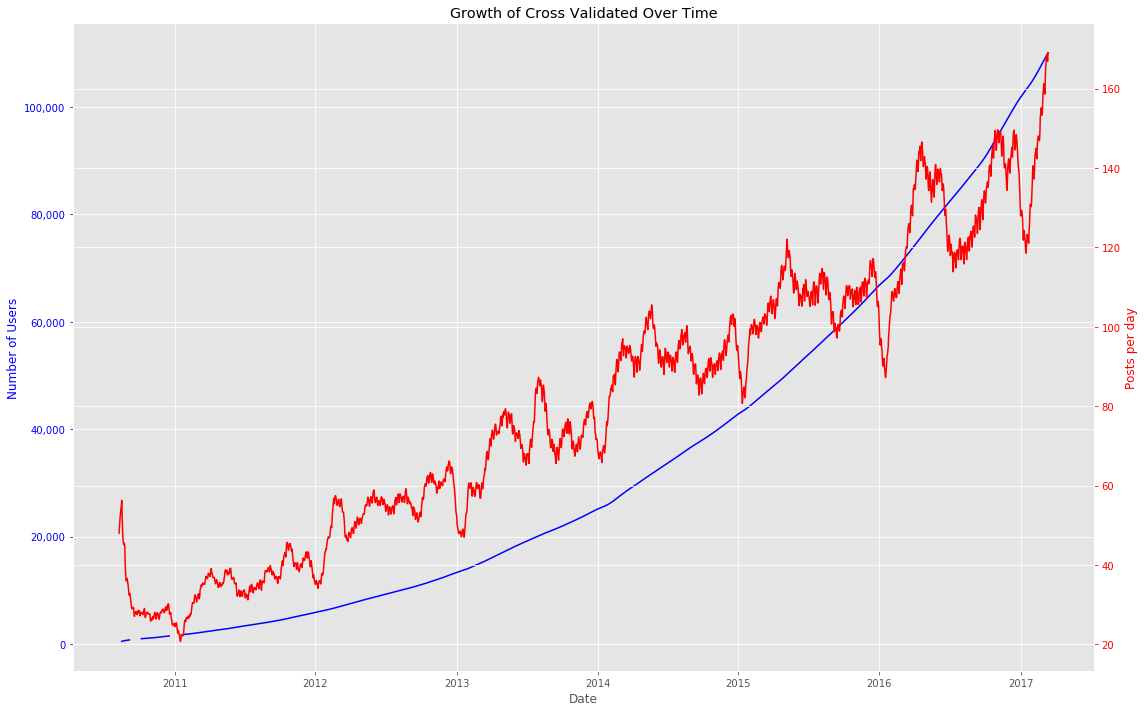

In [8]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.plot(posts_users.index, posts_users['users30dayMA'], color='b', label="Number of Users")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Number of Users', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(posts_users.index, posts_users['posts30dayMA'], color='r', label="Posts per Day (30 day MA)")
ax2.set_ylabel('Posts per day', color='r')
ax2.tick_params('y', colors='r')

ax1.set(title="Growth of Cross Validated Over Time")
def update_ylabels(ax):
    ylabels = [format(label, ',.0f') for label in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
update_ylabels(ax1)
fig.tight_layout()

## Graph two, number of posts vs. salary

Does making things easier to learn decrease salary?

In [ ]:
tags = ET.parse("stackoverflow/Tags.xml")
tags = tags.getroot()

tags = pd.DataFrame.from_dict([x.attrib for x in tags])
tags = tags.apply(pd.to_numeric, errors='ignore')
unique_tags = tags.TagName.unique()

survey2016['tags'] = survey2016.tech_do.str.lower() #.str.split("; *")

plotting_tags = tags.loc[tags.Count > 10000, :]
plotting_tags.loc[:, 'avg_salary'] = np.NaN
plotting_tags = plotting_tags.reset_index()

# TODO: don't use a loop here
# TODO: make sure to do a better job cleaning the tags before passing in
for i in range(len(plotting_tags)):
    tag = plotting_tags.loc[i, 'TagName']
    regex = re.escape(tag)
    # print(tag)
    plotting_tags.loc[i, 'avg_salary'] = survey2016.loc[survey2016.tags.str.contains(regex).fillna(False), 'salary_midpoint'].mean()

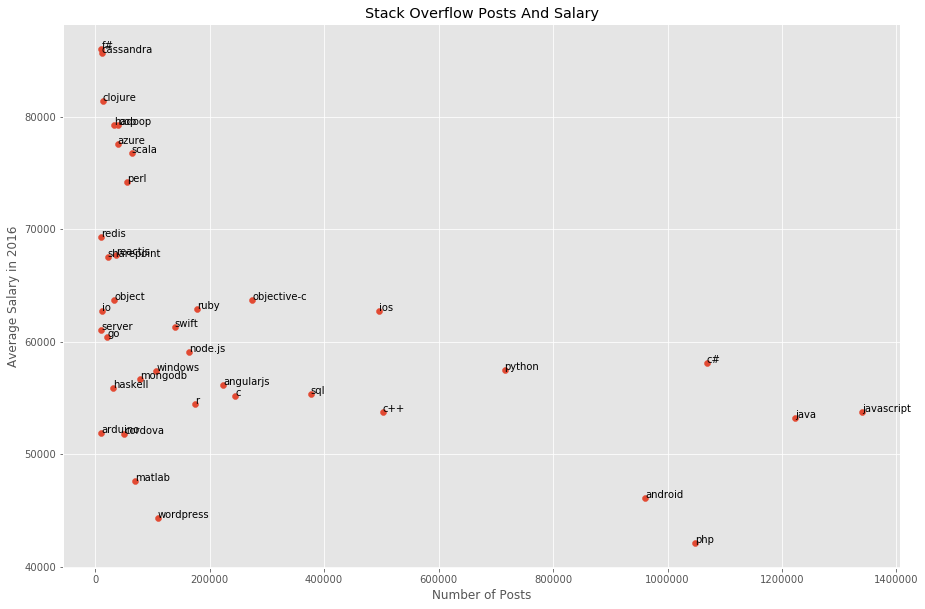

In [12]:
plt_tags = plotting_tags.loc[~plotting_tags.avg_salary.isnull()]
#fig, ax = plt.subplots()

#plt_tags.plot('Count', 'avg_salary', kind='scatter', ax=ax)

#for k, v in plt_tags.iterrows():
#    ax.annotate(plt_tags.loc[k, 'TagName'], plt_tags.loc[k, ['Count', 'avg_salary']])


# I'm not an expert at matplotlib so the graphics might be somewhat lacking
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(plt_tags.Count, plt_tags.avg_salary)
ax.set(xlabel='Number of Posts', ylabel='Average Salary in 2016', title="Stack Overflow Posts And Salary")
for k, v in plt_tags.iterrows():
    ax.annotate(plt_tags.loc[k, 'TagName'], plt_tags.loc[k, ['Count', 'avg_salary']])

## What the surveys contains on education already

2015 and 2016 surveys collect data on developer education, including whether they are self taught.

In [13]:
#Many people list more than one education type
education = survey2016.education.str.split('; ', expand=True).stack()

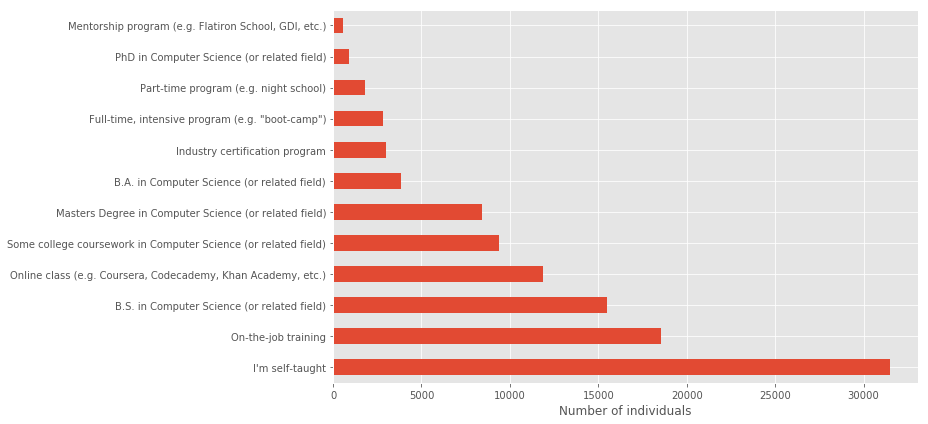

In [18]:
#basic plot of education counts
fig, ax = plt.subplots(figsize=(13,6))
education.value_counts().plot(kind='barh', rot=0)
plt.xlabel("Number of individuals")
plt.tight_layout()

In [21]:
#heatmap of overlap between categories
degrees = ["I'm self-taught",
           'On-the-job training',
           'Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)',
           'Full-time, intensive program (e.g. "boot-camp")',
           'Part-time program (e.g. night school)',
           'Some college coursework in Computer Science (or related field)',
           'B.A. in Computer Science (or related field)',
           'B.S. in Computer Science (or related field)',
           'Masters Degree in Computer Science (or related field)',
           'PhD in Computer Science (or related field)']

education_grid = pd.DataFrame(index=degrees, columns=degrees)

# use index slice for multiindex subsets
index_slice = pd.IndexSlice
for ed1 in education.unique():
    ix = education[education == ed1].index.get_level_values(0)
    number_with_education = len(ix)
    subset = education.loc[index_slice[ix,:]]
    for ed2 in subset.unique():
        # rows of the dataframe all have the same denominator: number of people with the ed.
        education_grid.loc[ed1,ed2] = np.sum(subset == ed2)/number_with_education

education_grid = education_grid.astype(float)

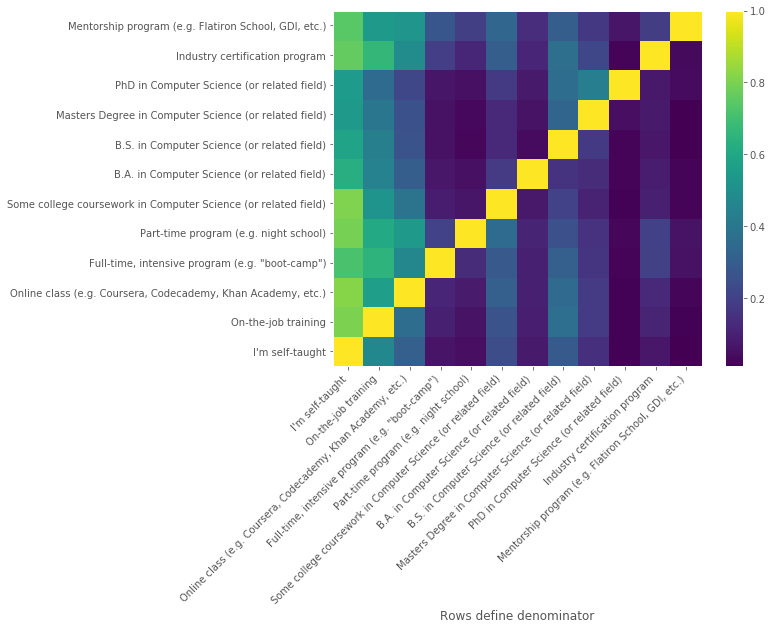

In [32]:
# People without formal education do seem to supplement, while people with PhDs seem to be the least "self taught"
# This might just be a problem with the survey design, since "self taught" and "on the job training" seem to
# imply that you didn't know anything beforehand
plt.close()
fig, ax = plt.subplots(figsize=(16,13))
plt.pcolor(education_grid)
plt.yticks(np.arange(0.5, len(education_grid.index), 1), education_grid.index)
plt.xticks(np.arange(0.5, len(education_grid.columns), 1), education_grid.columns, rotation=45, ha='right')
ax.set_xlabel("Rows define denominator")
fig.subplots_adjust(bottom=.5,left=0.5)
plt.colorbar()

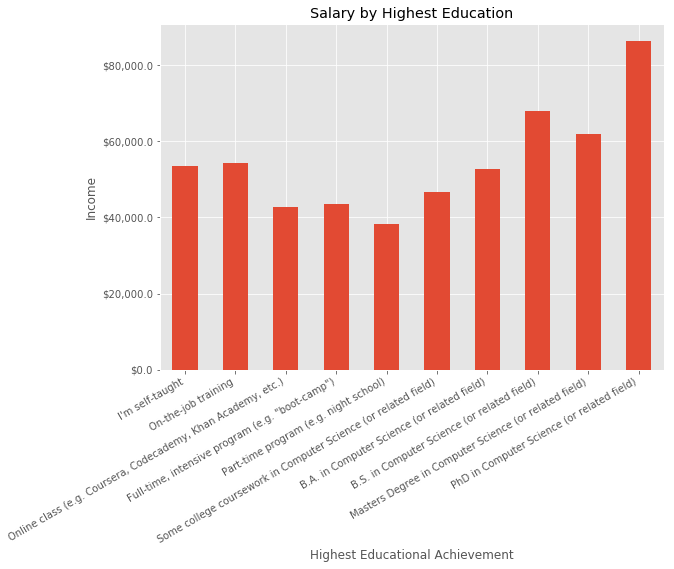

In [31]:
# education vs incomes
survey2016['highest_degree'] = "None"

for deg in degrees:
    survey2016.loc[survey2016.education.str.match(re.escape(deg)).fillna(False), 'highest_degree'] = deg
plt.close()
fig, ax = plt.subplots(figsize=(14, 10))
fig.subplots_adjust(bottom=.4, left=0.4)
survey2016.groupby('highest_degree')['salary_midpoint'].mean()[degrees].plot(kind='bar')
plt.xticks(np.arange(0, len(degrees), 1), degrees, rotation=30, ha='right')
ax.set_title("Salary by Highest Education")
ax.set_xlabel("Highest Educational Achievement")
ax.set_ylabel("Income")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '${:,}'.format(x)))

In the original data, survey respondants marked multiple languages they were proficient with. This presents a challenge, since we now have a non-rectangular dataset and substantial overlap between languages. One potential way forwards is to run a separate regression for each language.



## Controlling for geography, developer salaries compared to their peers

* survey data 2011 to 2013 only has large categories for Africa, Asia, and South America
* 2014 onwards seems to have full country list

In [34]:
#Combined with world bank data
pd.set_option('display.width', 100)
pd.set_option('display.float_format', '{:,.0f}'.format)
salary_gdp = pd.read_csv("output/salary_gdp2016.csv")
salary_gdp[salary_gdp['sample size'] > 100]

,country,avg. developer salary,gdp per cap,salary diff,sample size
6,Argentina,"27,063","13,467","13,596",362
8,Australia,"71,495","56,291","15,204","1,117"
9,Austria,"47,461","43,637","3,824",482
13,Bangladesh,"11,102","1,212","9,890",166
15,Belarus,"16,520","5,755","10,765",164
16,Belgium,"47,379","40,454","6,925",543
24,Brazil,"22,902","8,678","14,224","1,015"
25,Bulgaria,"21,899","6,993","14,905",246
30,Canada,"60,797","43,316","17,481","2,024"
33,Chile,"29,268","13,416","15,852",104


In [35]:
# Is there convergence in developer salaries across countries?

# What is the appropriate standard deviation measure here
# that takes into account sample size in developer salaries?
# Developer salaries when taking large sample sizes appear
# to be lower than gdp per capita variance,
salary_gdp.loc[salary_gdp['sample size'] > 200,
               ['gdp per cap', 'avg. developer salary']].apply(np.std)

gdp per cap             21,229
avg. developer salary   20,864
dtype: float64

In [ ]:
#TODO: look at how highest educational achievement is related to geography, to test whether access
# to education is different in different countries and whether this affects salary

## A simple regression?

In [89]:
survey_combined = pd.read_csv('Survey Data/survey_combined.csv') # all years 2011-2016
survey_languages = pickle.load(open('Survey Data/languages.pkl','rb'))

/home/allen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
survey_combined.columns

Index(['Unnamed: 0', 'income', 'year', 'age', 'country', 'yrs_exp', 'industry', 'company_size',
       'occupation', 'salary_midpoint', 'num_lang'],
      dtype='object')

In the survey data, survey respondants mark multiple languages they are proficient in. This presents a challenge, since we have a non-rectangular dataset and substantial overlap between languages. One potential way forwards is to run a separate regression for each language using a one-vs-all type strategy



In [120]:
dependent = "salary_midpoint"

explanatory = ["age", "country_gdp", "industry", "num_lang"]

# TODO:
# country is recorded differently in 2011-2013
# occupation has some categories that need combining
# yrs_exp currently messed up
# company size not defined for 2013 and 2014

#### Because languages have substantial overlap among observations, we will use a kind of one vs. all strategy.

In [91]:
# number of survey responses that claim to know the language
# lets use the top several. Maybe we should treat SQL or web frameworks differently?
survey_languages.value_counts().head(15)

javascript     52429
sql            44390
java           34930
c#             31462
php            26070
python         22673
c++            19504
c              16131
sql server     13435
android        12746
node.js        12672
angularjs      11758
ruby            8401
objective-c     7230
lamp            6747
dtype: int64

In [101]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

languages = list(survey_languages.value_counts().head(10).index)

In [102]:
# gotta include R
languages = languages + ['r']

In [122]:
results_dict = {}
index_slice = pd.IndexSlice
for lang in languages:
    # encode whether someone knows a language for the specific regression
    ix = survey_languages[survey_languages == lang].index.get_level_values(0)
    data = survey_combined.copy()
    data['lang'] = 0
    data.ix[ix, 'lang'] = 1
    data.dropna(inplace=True)
    X = pd.get_dummies(data[explanatory + ['lang']])
    y = data[dependent]
    lm.fit(X, y)
    results_dict[lang] = dict(zip(X.columns, lm.coef_))

In [123]:
#adjust for intercept
mean = np.mean([v['lang'] for k, v in results_dict.items()])
print(np.std([v['lang'] for k, v in results_dict.items()]))
for k, v in results_dict.items():
    print(k, "\t", v['lang']-mean)

429.339445005
javascript 	 307.005091524
sql 	 433.002179675
java 	 372.281773087
c# 	 -28.1861062914
php 	 -2.17140302152
python 	 345.507205228
c++ 	 92.1978444563
c 	 -541.596523056
sql server 	 -127.572964136
android 	 210.138616673
r 	 -1060.60571414


In [105]:
# Controlling for country GDP reduces variance
explanatory = ["age", "industry", "num_lang"]

In [113]:
results_dict2 = {}
index_slice = pd.IndexSlice
for lang in languages:
    # encode whether someone knows a language for the specific regression
    ix = survey_languages[survey_languages == lang].index.get_level_values(0)
    data = survey_combined.copy()
    data['lang'] = 0
    data.ix[ix, 'lang'] = 1
    data.dropna(inplace=True)
    X = pd.get_dummies(data[explanatory + ['lang']])
    y = data[dependent]
    lm.fit(X, y)
    results_dict2[lang] = dict(zip(X.columns, lm.coef_))

In [115]:
#adjust for intercept
mean = np.mean([v['lang'] for k, v in results_dict2.items()])
print(np.std([v['lang'] for k, v in results_dict2.items()]))
for k, v in results_dict2.items():
    print(k, "\t", v['lang'] - mean)

465.538606565
javascript 	 547.626969012
sql 	 575.87684375
java 	 533.363598619
c# 	 -47.2263565014
php 	 207.330592262
python 	 35.3576413166
c++ 	 -93.4540538295
c 	 -836.779160742
sql server 	 -40.1664604546
android 	 -39.6736310073
r 	 -842.255982424
